In [1]:
%pip install torch torchvision easyfsl opencv-python

Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
from torch import nn
import cv2
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
from easyfsl.methods import PrototypicalNetworks
import matplotlib.pyplot as plt

# Set device for computation
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using MPS for computation.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU for computation.")
else:
    device = torch.device("cpu")
    print("Using CPU for computation.")

MPS is available. Using MPS for computation.


In [9]:
# Image transformation pipeline
image_size = 224  # ResNet18 expects 224x224 input
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

In [10]:
# Set up the model
backbone = resnet18(weights='IMAGENET1K_V1')
backbone.fc = nn.Flatten()
backbone = backbone.to(device)
model = PrototypicalNetworks(backbone).to(device)

Successfully loaded sample image from ../../data/images/clear/sample/clear1c.png


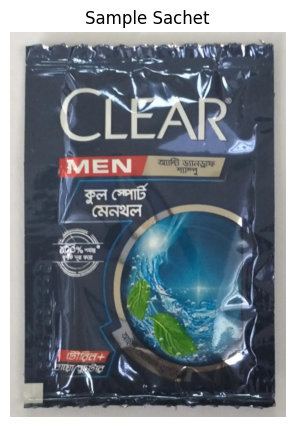

In [12]:
# Load and process sample image
sample_image_path = "../../data/images/clear/sample/clear1c.png"
try:
    original_sample, sample_tensor = load_and_preprocess_image(sample_image_path)
    print(f"Successfully loaded sample image from {sample_image_path}")
    
    # Display sample image
    plt.figure(figsize=(5, 5))
    plt.imshow(original_sample)
    plt.title("Sample Sachet")
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"Error loading sample image: {e}")

In [13]:
# Extract feature from sample image to create prototype
with torch.no_grad():
    sample_feature = model.backbone(sample_tensor)
    prototype = sample_feature.unsqueeze(0)  # Shape becomes [1, 1, feature_size]
    print(f"Prototype shape: {prototype.shape}")

Prototype shape: torch.Size([1, 1, 512])


In [15]:
# Function to detect sachets in the overall image
def detect_sachets_in_image(overall_image_path, distance_threshold=10.0, window_size=224, step_size=112, visualization=True):
    # Load the overall image
    try:
        image = cv2.imread(overall_image_path)
        if image is None:
            raise ValueError(f"Could not load image from {overall_image_path}")
        overall_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(f"Successfully loaded overall image from {overall_image_path}, shape: {overall_image.shape}")
    except Exception as e:
        print(f"Error loading overall image: {e}")
        return 0, None, []
    
    height, width, _ = overall_image.shape
    matches = 0
    detected_positions = []
    distance_scores = []
    
    # Create visualization image
    vis_image = overall_image.copy()
    
    print(f"Scanning image with window size {window_size}px and step size {step_size}px...")
    
    # Sliding window approach
    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            # Extract window
            window = overall_image[y:y + window_size, x:x + window_size]
            
            # Skip windows that are too small
            if window.shape[0] != window_size or window.shape[1] != window_size:
                continue
                
            # Transform window to tensor
            window_tensor = transform(window).unsqueeze(0).to(device)
            
            # Extract feature and calculate distance
            with torch.no_grad():
                window_feature = model.backbone(window_tensor)
                distance = torch.cdist(prototype, window_feature.unsqueeze(0)).item()
            
            distance_scores.append(distance)
            
            # Check if the window matches the prototype
            if distance < distance_threshold:
                matches += 1
                detected_positions.append((x, y, distance))
                
    # Sort detected positions by distance (confidence)
    detected_positions.sort(key=lambda x: x[2])
    
    # Non-maximum suppression to remove overlapping detections
    final_positions = []
    while detected_positions:
        best = detected_positions.pop(0)
        final_positions.append(best)
        
        # Remove overlapping detections
        i = 0
        while i < len(detected_positions):
            x1, y1, _ = best
            x2, y2, _ = detected_positions[i]
            
            # Calculate IoU
            intersection_x = max(0, min(x1 + window_size, x2 + window_size) - max(x1, x2))
            intersection_y = max(0, min(y1 + window_size, y2 + window_size) - max(y1, y2))
            intersection_area = intersection_x * intersection_y
            
            if intersection_area > (window_size * window_size * 0.5):  # 50% overlap threshold
                detected_positions.pop(i)
            else:
                i += 1
    
    # Draw rectangles for visualization
    if visualization and final_positions:
        for (x, y, dist) in final_positions:
            cv2.rectangle(vis_image, (x, y), (x + window_size, y + window_size), (0, 255, 0), 2)
            # Add distance text
            cv2.putText(vis_image, f"{dist:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(vis_image)
        plt.title(f"Detected Sachets: {len(final_positions)}")
        plt.axis("off")
        plt.show()
        
        # Show distance distribution
        if distance_scores:
            plt.figure(figsize=(10, 5))
            plt.hist(distance_scores, bins=50)
            plt.axvline(x=distance_threshold, color='r', linestyle='--')
            plt.title(f"Distance Distribution (threshold={distance_threshold})")
            plt.xlabel("Distance")
            plt.ylabel("Count")
            plt.show()
    
    return len(final_positions), vis_image, final_positions

In [16]:
# Function to find the optimal threshold
def find_optimal_threshold(overall_image_path, window_size=224, step_size=112):
    # Load the overall image
    try:
        image = cv2.imread(overall_image_path)
        if image is None:
            raise ValueError(f"Could not load image from {overall_image_path}")
        overall_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading overall image: {e}")
        return None
    
    height, width, _ = overall_image.shape
    all_distances = []
    
    # Collect distances for all windows
    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            window = overall_image[y:y + window_size, x:x + window_size]
            
            # Skip windows that are too small
            if window.shape[0] != window_size or window.shape[1] != window_size:
                continue
                
            window_tensor = transform(window).unsqueeze(0).to(device)
            
            with torch.no_grad():
                window_feature = model.backbone(window_tensor)
                distance = torch.cdist(prototype, window_feature.unsqueeze(0)).item()
            
            all_distances.append(distance)
    
    # Plot distance distribution
    plt.figure(figsize=(10, 5))
    plt.hist(all_distances, bins=50)
    plt.title("Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.show()
    
    return all_distances

Analyzing distance distribution to find optimal threshold...


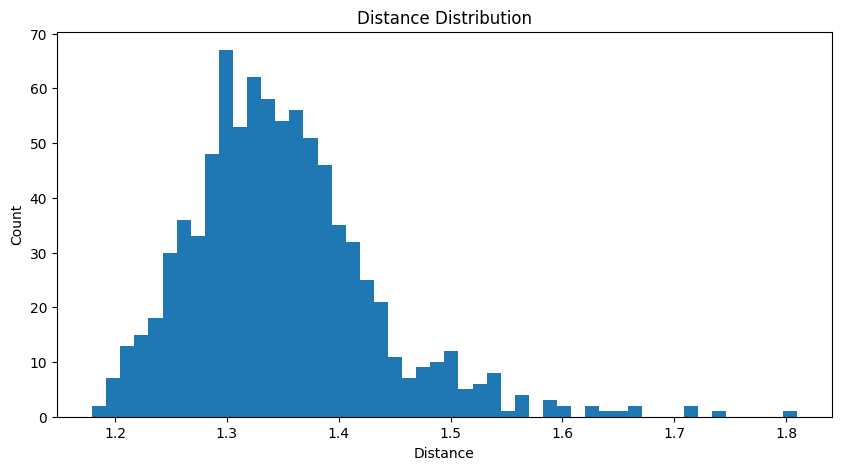

Suggested threshold based on distance distribution: 1.24


In [17]:
# Set the path to your test image
overall_image_path = "../../data/images/clear/query/z.jpg"

# Find optimal threshold
print("Analyzing distance distribution to find optimal threshold...")
distances = find_optimal_threshold(overall_image_path)

if distances:
    suggested_threshold = np.percentile(distances, 5)  # Bottom 5% as a starting point
    print(f"Suggested threshold based on distance distribution: {suggested_threshold:.2f}")

Successfully loaded overall image from ../../data/images/clear/query/z.jpg, shape: (3000, 4000, 3)
Scanning image with window size 224px and step size 112px...


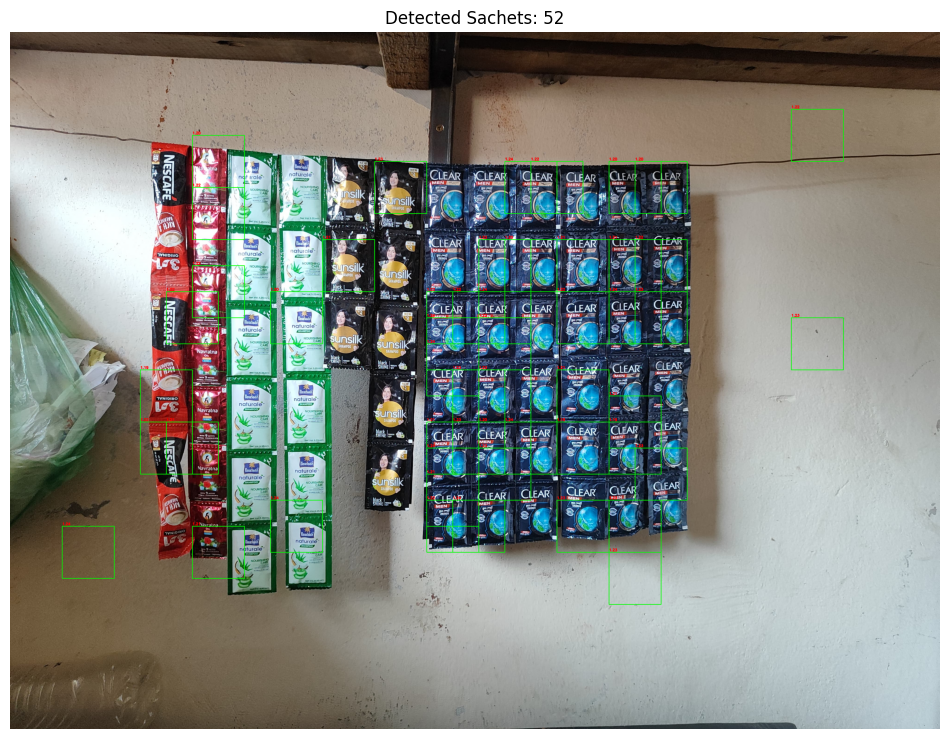

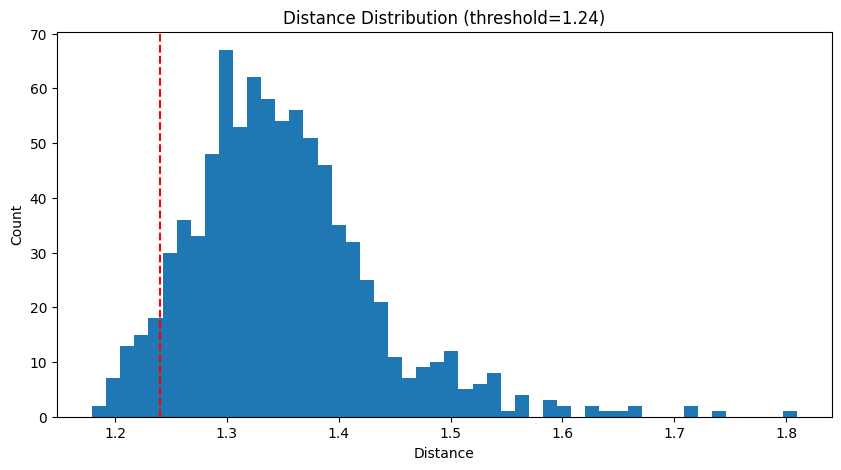

Final detection result: 52 sachets detected
Results saved to ./results/result1.jpg


In [18]:
user_threshold = 1.24

# Run detection with user-selected threshold
matches, vis_image, detected_positions = detect_sachets_in_image(
    overall_image_path, 
    distance_threshold=user_threshold
)
print(f"Final detection result: {matches} sachets detected")

if matches > 0 and vis_image is not None:
    result_path = "./results/result1.jpg"
    cv2.imwrite(result_path, cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR))
    print(f"Results saved to {result_path}")